This example shows the HelicalTangled magnetic field class, for a blazar jet magnetic field comprised of a helical and a tangled component. Values used for the jet properties come from the best fit of the Potter & Cotter model: Potter & Cotter 2015, https://ui.adsabs.harvard.edu/abs/2015MNRAS.453.4070P/

## Imports

In [1]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from ebltable.tau_from_model import OptDepth
from astropy import constants as c
from matplotlib.patheffects import withStroke
from astropy import units as u
from glob import glob
from IPython.display import Image, display
import time

In [2]:
effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])

In [3]:
%matplotlib inline

## Define the source

We will use Markarian 501 as the example.

In [4]:
src = Source(z = 0.034 , ra = '16h53m52.2s', dec = '+39d45m37s',
            ) # Mrk501
print (src.z)
print (src.ra, src.dec)
print (src.l, src.b)

0.034
253.4675 39.76027777777778
63.60017233364852 38.859218799553474


## Init the module list

Set up the module list with arbitrary ALP parameters. Energy range is roughly CTA energies.

In [5]:
EGeV = np.logspace(0.,5.,2000)

Unpolarised initial beam.

In [6]:
pin = np.diag((1.,1.,0.)) * 0.5

In [7]:
m = ModuleList(ALP(m = 1, g = 2), src, pin = pin, EGeV = EGeV, seed = 0, log_level="info")

Add the jet module. We will ignore any other magnetic fields. Here we use a field with 70% magnetic energy density in the tangled component, and a helical component which is a purely toroidal field. Values come from Potter & Cotter best fit. For the tangled field coherence length, we use a uniform distribution between 0.1 and 1. times the jet width at each point. This is chosen with the "l_tcor='jetwidth'" and "jwf_dist = 'Uniform'" options. l_tcor can also be given as a constant in parsecs, or the keyword 'jetdom' can be used to used the jet field domains as the tangled domains.

In [8]:
m.add_propagation("JetHelicalTangled", 
                  0, # position of module counted from the source. 
                  ndom = 400,
                  ft = 0.7, # fraction of magnetic field energy density in tangled field 
                  Bt_exp = -1., # exponent of the transverse component of the helical field
                  r_T = 0.3, # radius at which helical field becomes toroidal in pc
                  r0 = 0.3, # radius where B field is equal to b0 in pc
                  B0 = 0.8, # Bfield strength in G
                  g0 = 9., # jet lorenz factor at r0
                  n0 = 1.e4, # electron density at r0 in cm**-3
                  rjet = 98.3e+3, # jet length in pc
                  rvhe = 0.3, # distance of gamma-ray emission region from BH in pc
                  alpha = 1.68, # power-law index of electron energy distribution function
                  l_tcor='jetwidth', # tangled field coherence average length in pc if a constant, or keyword
                  #jwf = 1., # jet width factor used when calculating l_tcor = jwf*jetwidth
                  jwf_dist = 'Uniform' # type of distribution for jet width factors (jwf) 
                 )

    jet.py: 559 --- WARNING: Not resolving tangled field: min z step is 0.009857915102843562pc but min tangled length is 0.0010982609912778551 pc
    jet.py: 560 --- WARNING: # of z doms is 399 but # tangled doms is 176
    jet.py: 574 --- INFO: rerunning with 701 domains. new min z step is 0.00027456524781943603 pc
environs.py: 798 --- INFO: Using inputted chi


The default number of log-spaced field domains is 400 (this is enough to resolve the field for ALPs). In this case, however, this was not enough to resolve the tangled field. Therefore the number of domains was increased until the resolution was right and the module was re-run with 641 field domains, making sure that the edges line up with the 161 tangled component domains.

### Peek at the electron density and the magnetic field

The overall shape of the magnetic field strength in the jet comes from the Potter & Cotter model

Text(0, 0.5, 'Transverse B field [$\\mu$G]')

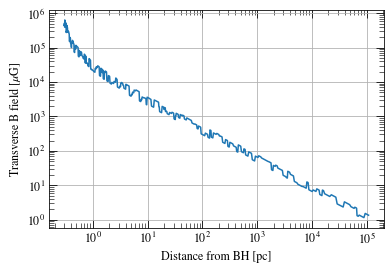

In [9]:
plt.loglog(m.modules[0]._r, m.modules[0].B)
plt.grid(True)
plt.xlabel('Distance from BH [pc]')
plt.ylabel('Transverse B field [$\mu$G]')

The electron density used to propagate the ALP-photon beam is not the actual electron density, but rather the effective electron density of a cold plasma that would give the save effective photon mass as the non-thermal plasma of the jet. That is why it appears lower here than the actual electron density inputted.

Text(0, 0.5, 'Effective Electron dentity [cm$^{-3}$]')

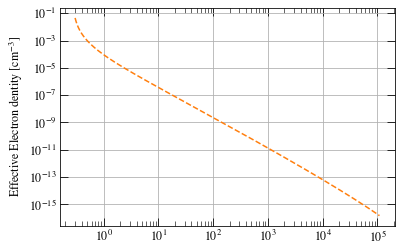

In [10]:
plt.loglog(m.modules["JetHelicalTangled"]._r, m.modules["JetHelicalTangled"].nel, color = plt.cm.tab10(0.1), ls = '--')
plt.grid(True)
plt.ylabel('Effective Electron dentity [cm$^{-3}$]')

### Compute the photon-ALP mixing probability

In [11]:
m.alp.m = 40.
m.alp.g = 0.6

In [12]:
px,py,pa = m.run(multiprocess=2)

### Plot the output

(1, 2000)
0.38052400646502554 0.4517655942887826


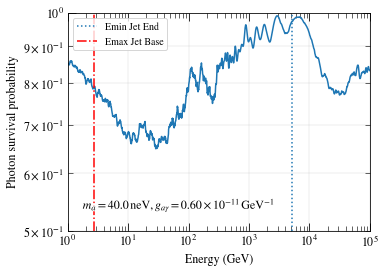

In [13]:
pgg = px + py # the total photon survival probability

print (pgg.shape)
print (px[0,-1], py[0,-1])

for p in pgg: # plot all realizations
    plt.plot(m.EGeV, p )

plt.grid(True, lw = 0.2)
plt.grid(True, which = 'minor', axis = 'y', lw = 0.2)

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon survival probability')


plt.gca().set_xscale('log')
plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.2f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(m.alp.m,m.alp.g),
             xy = (0.05,0.1), size = 'large', xycoords = 'axes fraction', ha = 'left',**effect)


# plt.axvline(transfer.EminGeV(m.alp.m, m.alp.g, m.modules[0].nel[0], m.modules[0].B[0]), ls = '--',label='Emin Base')
plt.axvline(transfer.EminGeV(m.alp.m, m.alp.g, m.modules[-1].nel[-1], m.modules[-1].B[-1]), ls = ':',label='Emin Jet End')
plt.axvline(transfer.EmaxGeV(m.alp.g, m.modules[0].B[0]), ls = '-.',color='red',label='Emax Jet Base')
# plt.axvline(transfer.EmaxGeV(m.alp.g, m.modules[-1].B[-1]), ls = '-',color='red',label='Emax End')
plt.gca().set_ylim(0.5,1.)
plt.gca().set_xlim(min(m.EGeV),max(m.EGeV))
plt.gca().set_yscale('log')
plt.subplots_adjust(left = 0.2)
plt.legend(loc = 'upper left', fontsize = 'medium')